In [1]:
import numpy as np
import tensorflow as tf
from keras.utils import np_utils
import matplotlib.pyplot as plt
from keras import regularizers

Using TensorFlow backend.


## PART A - TensorFlow and the Low Level API. [50 Marks]



### Question 1_2_3

L1 and L2 are commonly used regularization techniques. Implement and evaluate both
types of regularization for network architecture B (see below):

 - Layer 1: 300 neurons (ReLu activation functions).
 - Layer 2: 100 neurons (ReLu activation function)
 - Layer 3: Softmax Layer (from Q1 (i))


In [2]:
'''
Function from the assignment brief with modified return type
'''
def loadData():
    fashion_mnist = tf.keras.datasets.fashion_mnist

    # load the training and test data    
    (tr_x, tr_y), (te_x, te_y) = fashion_mnist.load_data()

    # reshape the feature data
    #print(tr_x.shape)

    tr_x = tr_x.reshape(tr_x.shape[0], 784)
    te_x = te_x.reshape(te_x.shape[0], 784)
    #print(tr_x.shape)

    # noramlise feature data
    tr_x = tr_x / 255.0
    te_x = te_x / 255.0

    print( "Shape of training features ", tr_x.shape)
    print( "Shape of test features ", te_x.shape)


    # one hot encode the training labels and get the transpose
    tr_y = np_utils.to_categorical(tr_y,10)
    tr_y = tr_y.T
    print ("Shape of training labels ", tr_y.shape)

    # one hot encode the test labels and get the transpose
    te_y = np_utils.to_categorical(te_y,10)
    te_y = te_y.T
    print ("Shape of testing labels ", te_y.shape)
    #Returning tensor flow variables
    return  tf.Variable(tr_x, dtype=tf.float32),  \
            tf.Variable(tr_y,  dtype=tf.float32), \
            tf.Variable(te_x,  dtype=tf.float32), \
            tf.Variable(te_y,  dtype=tf.float32)

#### Please make sure your code includes the following three functions:

In your report include your forward_pass function function for both of the above
network architectures. 

In [3]:
@tf.function
def forward_pass(x, w1, b1, w2, b2, w3, b3):
    #ReLu Layer 1 (Hidden Layer)
    t1 = tf.add(tf.matmul(x, w1), b1)
    relu1 = tf.math.maximum(t1, 0)
    #ReLu Layer2 (Hidden Layer)
    t2 = tf.add(tf.matmul(relu1, w2), b2)
    relu2 = tf.math.maximum(t2, 0)
    #Softmax Layer 
    t3 = tf.exp(tf.add(tf.matmul(relu2, w3), b3))
    sm =  t3 / tf.reduce_sum(t3, axis= 1, keepdims=True)
    return sm


In [4]:
@tf.function
#Modified function to include L1 and L2 regularisation
def cross_entropy(predicted, y, w1, w2, w3, regRate, reg="None"):
    ce = -tf.reduce_sum(tf.transpose(y) * tf.math.log(predicted), axis=1)
    #If L1 is selected
    if reg == "L1":
        weights = tf.reduce_sum(tf.math.abs(w1)) + tf.reduce_sum(tf.math.abs(w2))+ tf.reduce_sum(tf.math.abs(w3))
        loss = tf.reduce_mean(ce) + tf.multiply(regRate, weights)
    #If L2 is selected
    elif reg == "L2":
        weights = tf.reduce_sum(tf.math.square(w1)) + tf.reduce_sum(tf.math.square(w2))+ tf.reduce_sum(tf.math.square(w3))
        loss = tf.reduce_mean(ce) + tf.multiply(regRate, weights)
    else:
        #If noregularisation is selected
        loss = tf.reduce_mean(ce)
    return loss

In [5]:
#Implementation inpired from the link below to the tensor flow guide.
#https://www.tensorflow.org/guide/keras/train_and_evaluate
def calculate_accuracy(predicted, y):
    #Either transpose or run argmax on axis 1
    predicted = tf.argmax(predicted, axis=1)
    y = tf.argmax(y, axis=0)
    values = tf.cast(y, tf.int32) == tf.cast(predicted, tf.int32)
    values = tf.cast(values, tf.float32)
    accuracy = tf.reduce_mean(values)
    return accuracy


In [6]:
'''
Main run function
'''
def run(iterations, optimiser, numberOfClasses, dataSize, regRate=0, reg="None"):
    #Initialise layer 1 weights
    w1 = tf.Variable(tf.random.normal([dataSize, 300], mean=0.0, stddev=0.05, dtype=tf.float32))
    #Initialise layer 1 bias
    b1 = tf.Variable(tf.zeros([1, 300]))
    #Initialise layer 2 weights
    #input of layer 2 is 300, as that is the output of layer 1
    w2 = tf.Variable(tf.random.normal([300, 100], mean=0.0, stddev=0.05, dtype=tf.float32))
    #Initialise layer 2 bias
    b2 = tf.Variable(tf.zeros([1, 100]))
    #Inialise layer 3 weights
    #Input of layer 3 is 100, as this is the output of layer 2
    w3 = tf.Variable(tf.random.normal([100, numberOfClasses], mean=0.0, stddev=0.05, dtype=tf.float32))
    #Initialise layer 3 bias
    b3 = tf.Variable(tf.zeros([1, numberOfClasses]))
    for i in range(iterations):
        with tf.GradientTape() as tape:

            predictions = forward_pass(tr_x, w1, b1, w2, b2, w3, b3)
            loss = cross_entropy(predictions, tr_y, w1, w2, w3, regRate, reg )
            testPredictions = forward_pass(te_x, w1, b1, w2, b2, w3, b3)
            history['trainAccuracy'].append(calculate_accuracy(predictions, tr_y).numpy())
            history['trainLoss'].append(loss.numpy())
            history["testAccuracy"].append(calculate_accuracy(testPredictions, te_y).numpy())
            history["testLoss"].append(cross_entropy(testPredictions, te_y, w1, w2, w3, regRate, reg).numpy())
        #Run gradient descent wrt all weights and biases
        gradients = tape.gradient(loss, [w1, b1, w2, b2, w3, b3])
        optimiser.apply_gradients(zip(gradients, [ w1, b1, w2, b2, w3, b3]))

In [7]:
tr_x, tr_y, te_x, te_y = loadData()

Shape of training features  (60000, 784)
Shape of test features  (10000, 784)
Shape of training labels  (10, 60000)
Shape of testing labels  (10, 10000)


In [8]:
#Numer of classe is 10 as per the dataset
numberOfClasses = 10
#Run for 100 iterations
epochs = 100
accuracy = {}
#Initialise stats arrays
history ={}
history["trainAccuracy"] = []
history['trainLoss'] = []
history["testAccuracy"] = []
history['testLoss'] = []

inputSize = tr_x.shape[1]
regRate = tf.constant(0.001, dtype=tf.float32)



In [9]:
#Run model L1
regRate = tf.constant(0.0001, dtype=tf.float32)
run(epochs, tf.keras.optimizers.Adam(), numberOfClasses, tr_x.shape[1], regRate, "L1")

Summarise and visualise the results L1:

Train accuracy: 0.8461
Test accuracy: 0.8308
Train loss: 0.9414217
Test loss: 0.9718745




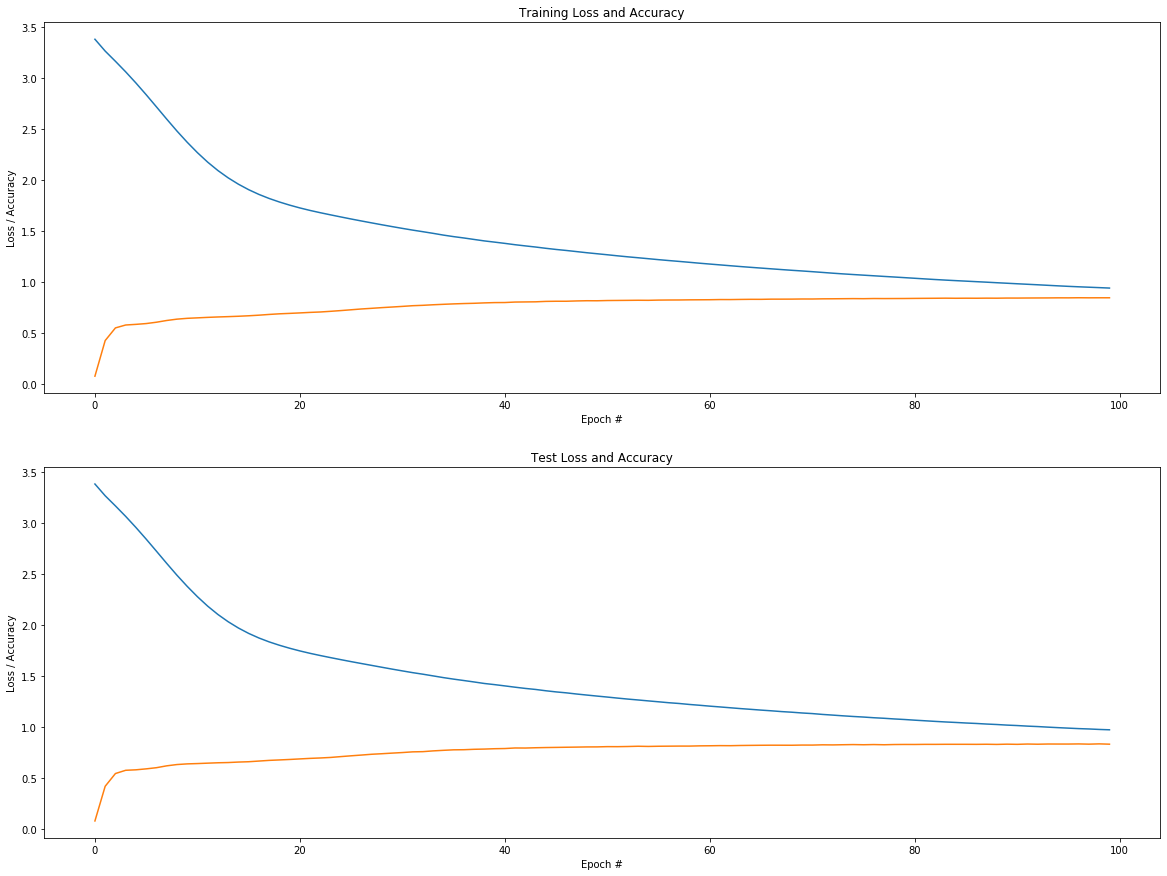

In [10]:
print('Train accuracy:', history['trainAccuracy'][-1])
print('Test accuracy:', history['testAccuracy'][-1])
print('Train loss:', history['trainLoss'][-1])
print('Test loss:', history['testLoss'][-1])
print("\n")


plt.figure(figsize=(20,15))
plt.subplot(2, 1, 1)
plt.plot(history['trainLoss'])
plt.plot(history['trainAccuracy'])
plt.xlabel('Epoch #')
plt.ylabel('Loss / Accuracy')
plt.title("Training Loss and Accuracy")

plt.subplot(2, 1, 2)
plt.plot(history['testLoss'])
plt.plot(history['testAccuracy'])
plt.xlabel('Epoch #')
plt.ylabel('Loss / Accuracy')
plt.title("Test Loss and Accuracy")


plt.show()

In [11]:
accuracy = {}
#Initialise stats arrays
history ={}
history["trainAccuracy"] = []
history['trainLoss'] = []
history["testAccuracy"] = []
history['testLoss'] = []

#Run model L1
regRate = tf.constant(0.001, dtype=tf.float32)
run(epochs, tf.keras.optimizers.Adam(), numberOfClasses, tr_x.shape[1], regRate, "L2")

Summarise and visualise the results L2:

Train accuracy: 0.85656667
Test accuracy: 0.8431
Train loss: 0.69084734
Test loss: 0.7226882




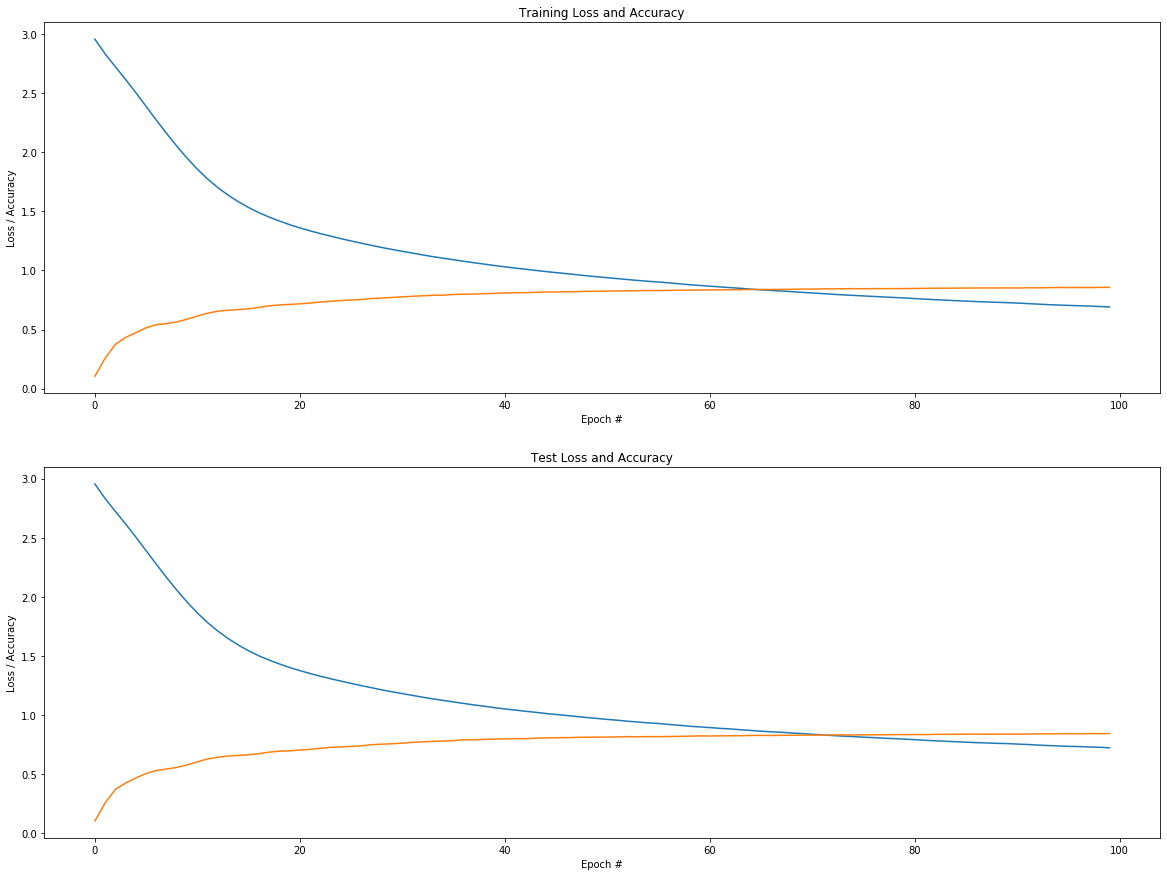

In [12]:
print('Train accuracy:', history['trainAccuracy'][-1])
print('Test accuracy:', history['testAccuracy'][-1])
print('Train loss:', history['trainLoss'][-1])
print('Test loss:', history['testLoss'][-1])
print("\n")


plt.figure(figsize=(20,15))
plt.subplot(2, 1, 1)
plt.plot(history['trainLoss'])
plt.plot(history['trainAccuracy'])
plt.xlabel('Epoch #')
plt.ylabel('Loss / Accuracy')
plt.title("Training Loss and Accuracy")

plt.subplot(2, 1, 2)
plt.plot(history['testLoss'])
plt.plot(history['testAccuracy'])
plt.xlabel('Epoch #')
plt.ylabel('Loss / Accuracy')
plt.title("Test Loss and Accuracy")


plt.show()